In [1]:
import os
from os.path import join, splitext, basename, dirname, abspath
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

In [2]:
from keras import initializations
from keras.optimizers import SGD, Adam

Using Theano backend.


In [2]:
import trading as trd
from trading import State, create_model, copy_model, track_model

Using Theano backend.


In [3]:
# relaod module after modifying it
import importlib
importlib.reload(trd)
importlib.reload(trd.stock_history)
importlib.reload(trd.portfolio)
importlib.reload(trd.benchmarks)
importlib.reload(trd.rl)
importlib.reload(trd.nn)
importlib.reload(trd)

<module 'trading' from 'C:\\Users\\hamza\\Documents\\school\\cs_229\\cs229_final_project\\src\\trading\\__init__.py'>

In [7]:
MODEL_DATA_LOC = '../data/model'

## Formulate Problem

In [3]:
# transaction cost to buy/sell a stock
trans_cost = 0.001
# starting cash
cash = 1e6
# starting portfolio allocation (%lo, %hi)
starting_weights = (0.5, 0.5)
# reward function (either Sharpe Ratio or last reward)
reward = trd.sharpe_ratio_reward

In [4]:
# total number of portfolios
M = 36
# size of training set
m = 27
# number of days input
d = 7
# pentalty on volatility
λ = 2

## Data

In [5]:
train_data, test_data = trd.get_stock_pairs(m)

In [6]:
portfolio_states = [State(p, cash=cash, target_weights=starting_weights, trans_cost=trans_cost, d=d) for p in train_data]
# list to delete from, keep all the portfolio states in portfolio_states
#  generates a (shallow) copy rather than copy the list's reference 
available_states = portfolio_states[:]

## (hyper)Parameters

## Start Training


iter:        0	loss:  5.2374e-18      

iter:     2500	loss:  0.000222749     

iter:     5000	loss:  2.16577e-05     

iter:     7500	loss:  8.27221e-05     

iter:    10000	loss:  2.50785e-05     

iter:    12500	loss:  1.00497e-05     

iter:    15000	loss:  3.02259e-05     


## Testing

In [17]:
test_states = [State(p, cash=cash, target_weights=starting_weights, trans_cost=trans_cost) for p in test_data]
available_test_states = test_states[:]

In [18]:
while True:
    if available_test_states == []:
        break
    
    states = np.array([st.state for st in available_test_states])
 
    qvalues = model.predict(states)
    chosen_actions = np.argmax(qvalues, axis=1)
    
    for (st, a) in zip(available_test_states, trd.actions[chosen_actions]):
        # execute the action
        st.execute_trade(a)

        try:
            st.step()
        except StopIteration:
            available_test_states.remove(st)

In [46]:
MODEL_DIR = '{:d}h_{:s}_{:d}eps_{:d}init'.format(H, non_lin, int(ϵ*100), int(cash))
MODEL_DIR = join(MODEL_DATA_LOC, MODEL_DIR)
try:
    os.mkdir(MODEL_DIR)
except Exception:
    pass

In [48]:
model.save(join(MODEL_DIR, 'model.h5'))

In [47]:
for st in test_states:
    file_name = '{:s}_{:s}.csv'.format(st.lo.symbol, st.hi.symbol)
    st.portfolio.to_csv(join(MODEL_DIR, file_name))

In [9]:
def cust_plt(ax, data, label='', **kwargs):
    ax.plot_date(data.index, data, ls='solid', marker='', label=label, **kwargs)

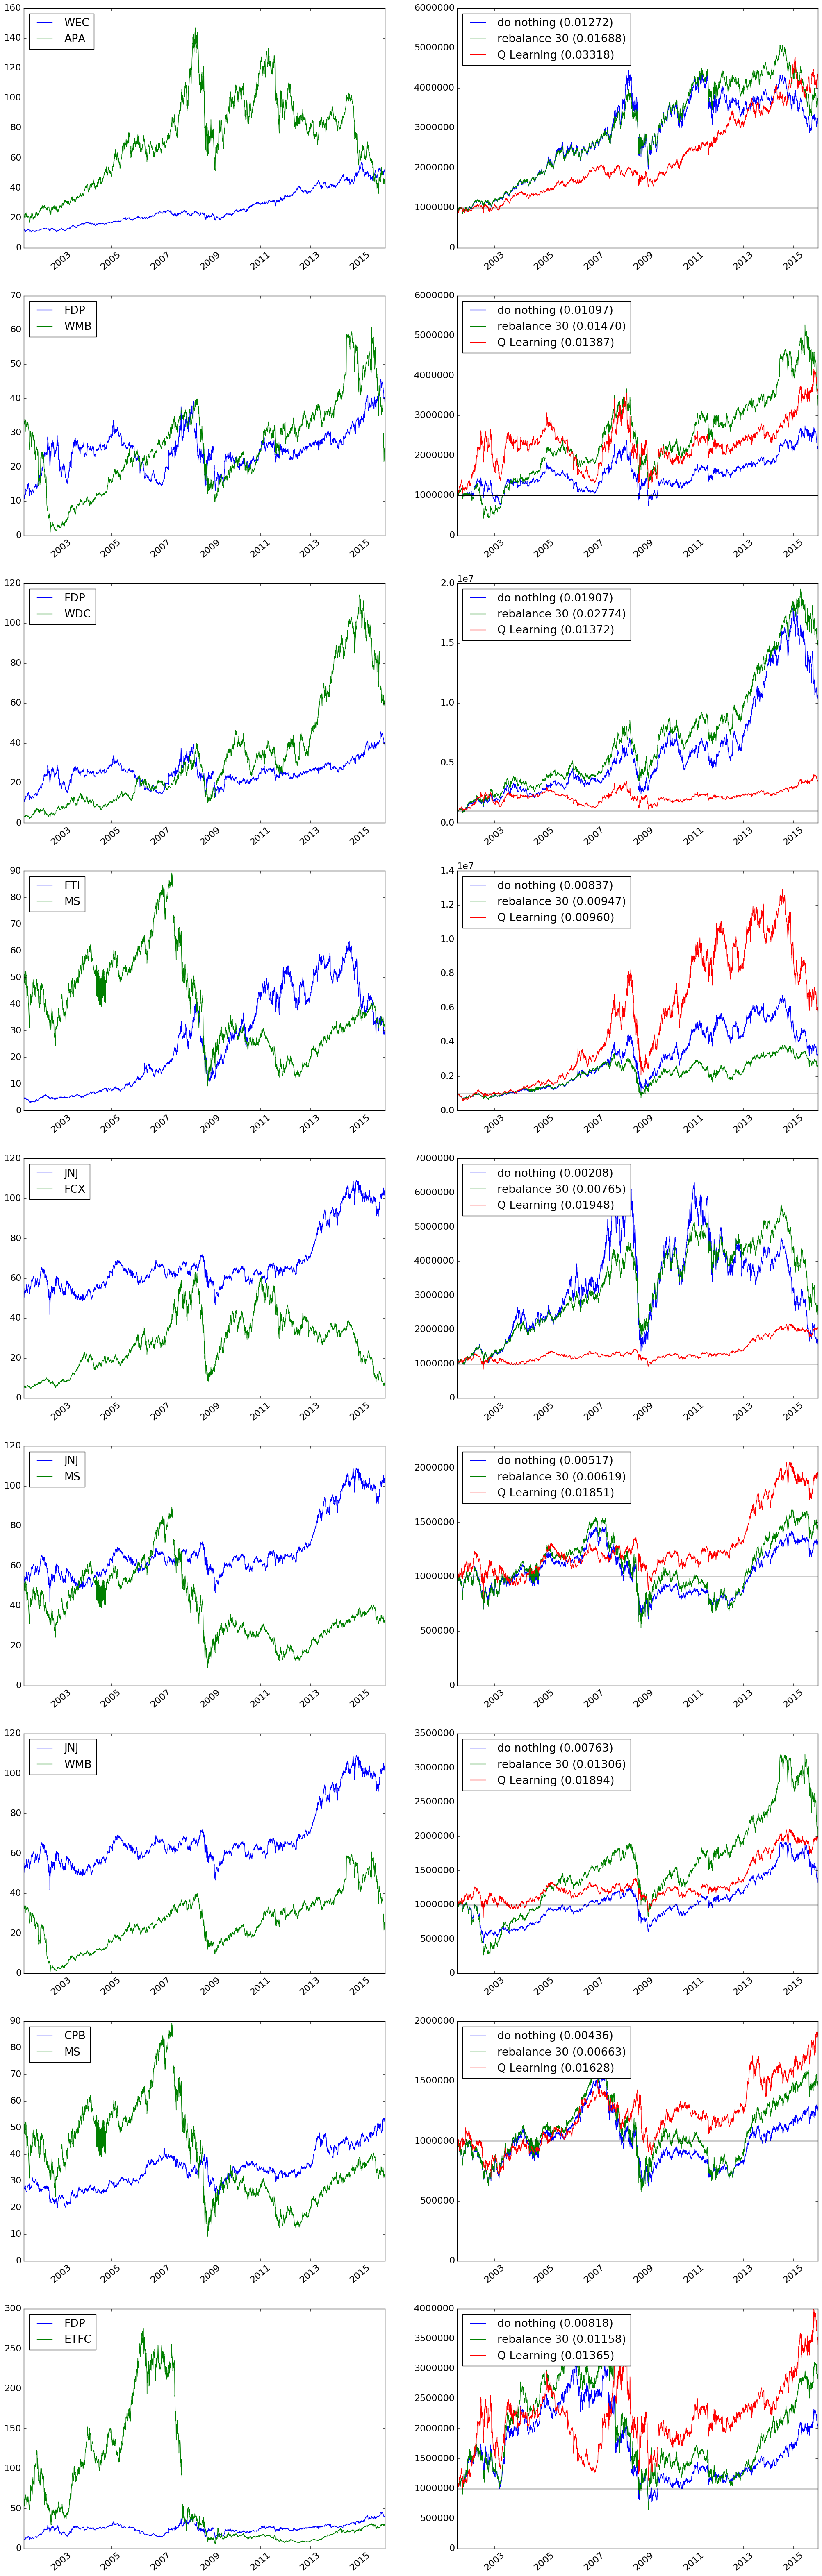

In [28]:
# number of test examples
N = M - m

matplotlib.rc('font', size=16)
f = plt.figure(figsize=(25, 80))

for i, st in enumerate(test_states):
    lo_name = st.lo.symbol
    hi_name = st.hi.symbol
    lo = st.portfolio.cost_lo
    hi = st.portfolio.cost_hi
    q = st.portfolio.total
    
    ax1 = plt.subplot(N, 2, 2*i + 1)
    cust_plt(ax1, lo, lo_name)
    cust_plt(ax1, hi, hi_name)
    ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xticks(rotation=40)
    
    do_nothing = trd.do_nothing_benchmark(lo, hi, 
                                          trans_cost=trans_cost, 
                                          initial_value=cash)
    rebal = trd.rebalance_benchmark(lo, hi, rebalance_period=30, 
                                    initial_value=cash, 
                                    trans_cost=trans_cost)

    ax2 = plt.subplot(N, 2, 2*i + 2)
    lbl_str = '{:s} ({:.5f})'
    cust_plt(ax2, do_nothing.total, lbl_str.format('do nothing', reward(do_nothing)))
    cust_plt(ax2, rebal.total, lbl_str.format('rebalance 30', reward(rebal)))
    cust_plt(ax2, st.portfolio.total, lbl_str.format('Q Learning', reward(st.portfolio)))
    ax2.axhline(y=cash, color='black')
    ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    ax2.set_ylim(bottom=0)
    plt.xticks(rotation=40)

In [27]:
f.savefig('nn_cmp.png')